In [175]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import plotly

import time
from datetime import datetime
import datetime as dt

import mysql.connector
from sqlalchemy import create_engine

# for decoding the downloaded files
import io

In [176]:
# Making API call to PushShift API
import requests

In [22]:
def utc_to_date_obj(date):
    str_date = time.strftime("%Y-%m-%d", time.localtime(date))
    date_obj = datetime.strptime(str_date, "%Y-%m-%d").date()
    return date_obj

## Optional Code Block Below: I am using it to store the data in my MySQL db.

In [177]:
db = 'wsb_data'
db_tbl_name = 'wsb_comments'

'''
Create a mapping of df dtypes to mysql data types (not perfect, but close enough)
'''
def dtype_mapping():
    return {'object' : 'TEXT',
        'int64' : 'INT',
        'float64' : 'FLOAT',
        'datetime64' : 'DATETIME',
        'bool' : 'TINYINT',
        'category' : 'TEXT',
        'timedelta[ns]' : 'TEXT'}

'''
Create a sqlalchemy engine
'''
def mysql_engine(user = 'root', password = 'Blackstar5140!', host = '127.0.0.1', port = '3306', database = db):
    engine = create_engine("mysql://{0}:{1}@{2}:{3}/{4}?charset=utf8mb4".format(user, password, host, port, database))
    return engine

'''
Create a mysql connection from sqlalchemy engine
'''
def mysql_conn(engine):
    conn = engine.raw_connection()
    return conn

'''
Create sql input for table names and types
'''
def gen_tbl_cols_sql(df):
    dmap = dtype_mapping()
    sql = "comment_id INT AUTO_INCREMENT PRIMARY KEY"
    df1 = df.rename(columns = {"" : "nocolname"})
    hdrs = df1.dtypes.index
    hdrs_list = [(hdr, str(df1[hdr].dtype)) for hdr in hdrs]
    for i, hl in enumerate(hdrs_list):
        sql += " ,{0} {1}".format(hl[0], dmap[hl[1]])
    return sql

'''
Create a mysql table from a df
'''
def create_mysql_tbl_schema(df, conn, db, tbl_name):
    tbl_cols_sql = gen_tbl_cols_sql(df)
    sql = "USE {0}; CREATE TABLE {1} ({2})".format(db, tbl_name, tbl_cols_sql)
    cur = conn.cursor()
    cur.execute(sql)
    cur.close()
    conn.commit()

'''
Write df data to newly create mysql table
'''
def df_to_mysql(df, engine, tbl_name):
    df.to_sql(tbl_name, engine, if_exists='append', method='multi')

In [180]:
from sqlalchemy import text

In [182]:
# Extract the data from the MySQL database
# SQL Code to run
sql_code = text("""
select * 
from wsb_data.wsb_comments;
""")

# creating an engine with attributes provided
sql_engine = mysql_engine()
# establishing connection with the database
sql_connection = sql_engine.connect()
# Executing the sql code.
extracted_data = sql_connection.execute(sql_code)

In [183]:
df_from_database = pd.read_sql(sql_code, sql_connection)

In [184]:
df_from_database

,index,author,body,subreddit,subreddit_name_prefixed,permalink,timestamp
0,0,Stantron,Range rover? Nobody I know gives a fuck about ...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s23l13/cnbc_profile...,2022-01-12
1,1,Neemzeh,"""massive volume sell off"". wtf are you even ta...",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s23o5c/daily_discus...,2022-01-12
2,2,AutoModerator,Your submission was removed from /r/wallstreet...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s2ca2d/apple_3t_mar...,2022-01-12
3,3,deadmancaulking,OPEN being my best performing stock today was ...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s23o5c/daily_discus...,2022-01-12
4,4,Turd-Lipstick,Scalping calls. I'll make a quick $2k or whate...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s23o5c/daily_discus...,2022-01-12
...,...,...,...,...,...,...,...
122743,22643,Bebop123123123,Same xx shares and those calls,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5jy0t/are_my_04feb...,2022-01-17
122744,22644,VisualMod,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5s9wc/ai_nodes/hsz...,2022-01-17
122745,22645,theCramps,Thank you!,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s42gw0/weekend_disc...,2022-01-17
122746,22646,ColaHelixSurge,"barely down bro, barely.",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s42gw0/weekend_disc...,2022-01-17


In [190]:
# When making changes to the database in the form of making updates, deletions or inserts, you need to commit the changes.
# creating an engine with attributes provided
sql_engine2 = mysql_engine()
# establishing connection with the database. Need to use raw_connection()
sql_connection2 = sql_engine2.raw_connection()

# cursor in order to write sql queries with changes that are being made to the database. Not just select and extract keywords.
cursor2 = sql_connection2.cursor()
# cursor2.execute("USE wsb_data; DROP TABLE test_tb, test_tb2, test_tb3;")
cursor2.close()
sql_connection2.commit()

## Ending of Optional Code Block

## Now this is the NOT Optional Code Block. Run every code block from the below one to the last one included

In [191]:
from pmaw import PushshiftAPI
api = PushshiftAPI()

In [192]:
dt.datetime.now()

datetime.datetime(2022, 1, 17, 14, 15, 46, 266112)

In [200]:
# Select how many days from today you want to look back to download the data for selected time period
# if you want to download the data only for today, then keep the days=1, hence from yesterday-today
days_delta = dt.timedelta(days=1)

In [201]:
start_date = dt.datetime.now() - days_delta
start_date = int(start_date.timestamp())
start_date

1642332009

In [202]:
end_date = dt.datetime.now()
end_date = int(end_date.timestamp())
end_date

1642418410

In [203]:
# Setting subreddit to pull comments from and number of comments to pull in form of a limit value
subreddit="wallstreetbets"
limit=50000

In [204]:
# Please expect to take some time to download this, i.e. the bigger the number like 100,000 then expect like 10 minutes download time due to reddit api 100 comments per request limit.
# The api defaults to extracting the newest/latest comments first
comments_data = api.search_comments(subreddit=subreddit, limit=limit, before=end_date, after=start_date)

print(f'Retrieved {len(comments_data)} comments from Pushshift')

INFO:pmaw.PushshiftAPIBase:27175 result(s) not found in Pushshift
INFO:pmaw.PushshiftAPIBase:Checkpoint:: Success Rate: 80.00% - Requests: 100 - Batches: 10 - Items Remaining: 14847
INFO:pmaw.PushshiftAPIBase:Checkpoint:: Success Rate: 79.50% - Requests: 200 - Batches: 20 - Items Remaining: 7304
INFO:pmaw.PushshiftAPIBase:Checkpoint:: Success Rate: 78.00% - Requests: 300 - Batches: 30 - Items Remaining: 1580
INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 77.87% - Requests: 348 - Batches: 35 - Items Remaining: 51
INFO:pmaw.PushshiftAPIBase:51 result(s) not found in Pushshift
Retrieved 22774 comments from Pushshift


In [205]:
# Here stores the downloaded comments into a dataframe.
full_df = pd.DataFrame(comments_data)

In [206]:
full_df

,all_awardings,archived,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,...,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_type,top_awarded_type,total_awards_received,treatment_tags,unrepliable_reason,media_metadata,author_cakeday
0,[],False,None,mrmilkman,None,None,[],None,None,None,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,None,0,[],None,NaN,NaN
1,[],False,None,Street-Badger,None,None,[],None,None,None,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,None,0,[],None,NaN,NaN
2,[],False,None,[deleted],,None,NaN,None,None,dark,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,None,0,[],None,NaN,NaN
3,[],False,None,Lurker9605,#ffffff,None,"[{'a': ':cb5lgbt:', 'e': 'emoji', 'u': 'https:...",acf21f8a-b20b-11e8-8717-0ee9cf2d415a,:cb5lgbt:,dark,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,None,0,[],None,NaN,NaN
4,[],False,None,inkmajor530,,None,[],None,,,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,None,0,[],None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22769,[],False,None,tothepointe,None,None,[],None,None,None,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,None,0,[],None,NaN,NaN
22770,[],False,None,Vibe_Check_Failure,None,None,[],None,None,None,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,None,0,[],None,NaN,NaN
22771,[],False,None,NES_WallStreetKid,,None,"[{'e': 'text', 't': '🦍🦍'}]",None,🦍🦍,dark,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,None,0,[],None,NaN,NaN
22772,[],False,None,HellYeah11,None,None,[],None,None,None,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,None,0,[],None,NaN,NaN


In [207]:
# Saving the downloaded data into a csv file to store the data.
# you can change the name of the file to whatever you want.
full_df.to_csv('./wsb_comments_17_jan.csv', header=True, index=False, columns=list(full_df.axes[1]))

In [208]:
# importing a csv file to put in the database
df_put = pd.read_csv("wsb_comments_17_jan.csv")

In [209]:
df_put

,all_awardings,archived,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,...,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_type,top_awarded_type,total_awards_received,treatment_tags,unrepliable_reason,media_metadata,author_cakeday
0,[],False,NaN,mrmilkman,NaN,NaN,[],NaN,NaN,NaN,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,NaN,0,[],NaN,NaN,NaN
1,[],False,NaN,Street-Badger,NaN,NaN,[],NaN,NaN,NaN,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,NaN,0,[],NaN,NaN,NaN
2,[],False,NaN,[deleted],NaN,NaN,NaN,NaN,NaN,dark,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,NaN,0,[],NaN,NaN,NaN
3,[],False,NaN,Lurker9605,#ffffff,NaN,"[{'a': ':cb5lgbt:', 'e': 'emoji', 'u': 'https:...",acf21f8a-b20b-11e8-8717-0ee9cf2d415a,:cb5lgbt:,dark,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,NaN,0,[],NaN,NaN,NaN
4,[],False,NaN,inkmajor530,NaN,NaN,[],NaN,NaN,NaN,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,NaN,0,[],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22769,[],False,NaN,tothepointe,NaN,NaN,[],NaN,NaN,NaN,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,NaN,0,[],NaN,NaN,NaN
22770,[],False,NaN,Vibe_Check_Failure,NaN,NaN,[],NaN,NaN,NaN,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,NaN,0,[],NaN,NaN,NaN
22771,[],False,NaN,NES_WallStreetKid,NaN,NaN,"[{'e': 'text', 't': '🦍🦍'}]",NaN,🦍🦍,dark,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,NaN,0,[],NaN,NaN,NaN
22772,[],False,NaN,HellYeah11,NaN,NaN,[],NaN,NaN,NaN,...,wallstreetbets,t5_2th52,r/wallstreetbets,public,NaN,0,[],NaN,NaN,NaN


In [210]:
# Saving the data to the database
df_put = df_put[['author', 'body', 'subreddit', 'subreddit_name_prefixed', 'permalink', 'created_utc']]

In [211]:
df_put['created_utc'] = df_put['created_utc'].apply(lambda x: utc_to_date_obj(x))

/var/folders/73/49djygss0073nqm4j66sj7f00000gn/T/ipykernel_89979/2440738758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_put['created_utc'] = df_put['created_utc'].apply(lambda x: utc_to_date_obj(x))


In [212]:
df_put.rename(columns={"created_utc":"timestamp"}, inplace=True)

/Users/nikitaizmailov/ml/nlp_project/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [213]:
cols = df_put.columns
list(cols)

['author',
 'body',
 'subreddit',
 'subreddit_name_prefixed',
 'permalink',
 'timestamp']

In [214]:
# Storing the data in the database.
# Optional code block.
# df_to_mysql(df_put, mysql_engine(), db_tbl_name)

In [169]:
# Optional Code block.
# # Extract the data from the MySQL database
# # SQL Code to run
# sql_code = text("""
# select * 
# from wsb_data.wsb_comments;
# """)

# # creating an engine with attributes provided
# sql_engine = mysql_engine()
# # establishing connection with the database
# sql_connection = sql_engine.connect()
# # Executing the sql code.
# extracted_data = sql_connection.execute(sql_code)

In [172]:
# Code block to assign the extracted data to a variable
#all_comments_df = pd.DataFrame(extracted_data)

In [215]:
# If you don't want to extract the data from the sql db, just run this line below instead.
all_comments_df = df_put.copy()

In [216]:
# Preprocessing Data to put in correct from in the dataframe

In [217]:
# Don't run this line below if you didnt extract the data from the database.
def drop_column(column_delete, df):
    df.drop(labels=[column_delete], axis=1, inplace=True)
    return df
#all_comments_df = drop_column(int(0), all_comments_df)

In [218]:
# Renaming the columns
all_comments_df.columns = ['author',
 'body',
 'subreddit',
 'subreddit_name_prefixed',
 'permalink',
 'timestamp']

In [219]:
all_comments_df

,author,body,subreddit,subreddit_name_prefixed,permalink,timestamp
0,mrmilkman,"That oil goes on the international market, it'...",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5tijg/oxy/hszwehd/,2022-01-17
1,Street-Badger,"No, they’re better than poor people, and in ad...",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s42gw0/weekend_disc...,2022-01-17
2,[deleted],[removed],wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5qdbi/a_year_after...,2022-01-17
3,Lurker9605,Theyre making 6 figures and investing in ETFs ...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s42gw0/weekend_disc...,2022-01-17
4,inkmajor530,"Sofi a solid company, palantir also. You got ...",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5udwx/i_put_my_sav...,2022-01-17
...,...,...,...,...,...,...
22769,tothepointe,Except isn't the student loan-backed securitie...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s4oo21/im_thinking_...,2022-01-17
22770,Vibe_Check_Failure,Puts on SPY for sure,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5608c/buyerman_the...,2022-01-17
22771,NES_WallStreetKid,People are shorting Netflix???,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s4z8i9/youre_all_ab...,2022-01-17
22772,HellYeah11,Sick you could buy when markets are closed tom...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5j5yf/what_stocks_...,2022-01-17


In [220]:
# lets check for duplicate comments and drop them if found.
check_dupes = all_comments_df.loc[all_comments_df.duplicated(keep=False)]

In [225]:
check_dupes

,author,body,subreddit,subreddit_name_prefixed,permalink,timestamp


In [226]:
# keeping the first occurence of duplicates and dropping the subsequent occurence of them rows
def drop_dupes(df):
    indicies_of_rows = df.loc[df.duplicated(keep='last')].index
    indicies_of_rows = list(indicies_of_rows)
    df.drop(labels=indicies_of_rows, axis=0, inplace=True)
    return df
all_comments_df = drop_dupes(all_comments_df)

In [227]:
# dropping rows where the author and comment body has been deleted
def drop_author_body_empty(df):
    rows_empty = df.loc[(df['author']=="[deleted]") | df['body']=="[deleted]"].index
    rows_empty = list(rows_empty)
    df.drop(labels=rows_empty, axis=0, inplace=True)
    return df
all_comments_df = drop_author_body_empty(all_comments_df)

In [228]:
# As we can see now we don't have duplicated rows
all_comments_df.loc[all_comments_df.duplicated()]

,author,body,subreddit,subreddit_name_prefixed,permalink,timestamp


In [229]:
# checking for empty strings/NaNs or Nulls
all_comments_df.loc[(all_comments_df['body'] == 'None') | (pd.isna(all_comments_df['body']))]

,author,body,subreddit,subreddit_name_prefixed,permalink,timestamp


In [230]:
# Deleting empty rows
def delete_empty(df):
    rows_to_del = df.loc[(df['body'] == 'None') | (pd.isna(df['body']))].index
    df.drop(labels=rows_to_del, axis=0, inplace=True)
    return df
all_comments_df = delete_empty(all_comments_df)

In [231]:
all_comments_df = all_comments_df.reset_index(drop=True)
all_comments_df

,author,body,subreddit,subreddit_name_prefixed,permalink,timestamp
0,mrmilkman,"That oil goes on the international market, it'...",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5tijg/oxy/hszwehd/,2022-01-17
1,Street-Badger,"No, they’re better than poor people, and in ad...",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s42gw0/weekend_disc...,2022-01-17
2,[deleted],[removed],wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5qdbi/a_year_after...,2022-01-17
3,Lurker9605,Theyre making 6 figures and investing in ETFs ...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s42gw0/weekend_disc...,2022-01-17
4,inkmajor530,"Sofi a solid company, palantir also. You got ...",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5udwx/i_put_my_sav...,2022-01-17
...,...,...,...,...,...,...
22769,tothepointe,Except isn't the student loan-backed securitie...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s4oo21/im_thinking_...,2022-01-17
22770,Vibe_Check_Failure,Puts on SPY for sure,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5608c/buyerman_the...,2022-01-17
22771,NES_WallStreetKid,People are shorting Netflix???,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s4z8i9/youre_all_ab...,2022-01-17
22772,HellYeah11,Sick you could buy when markets are closed tom...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5j5yf/what_stocks_...,2022-01-17


In [232]:
# Goal1: Extracting the ticker mentions from each comment and then plotting the Bar Chart with count for each stock ticker mentioned.

In [233]:
# Creating a NLP Pipeline.
import spacy

In [234]:
nlp = spacy.load('en_core_web_sm')

In [241]:
# Testing out the SpaCy NLP model with arbitrary selected value
txt = all_comments_df['body'][4]

In [242]:
txt

'Sofi a solid company,  palantir also. You got a few good picks in there. They will turn around in time.'

In [243]:
doc = nlp(txt)

In [244]:
entities = []
labels = []
position_start = []
position_end = []

for ent in doc.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)

df = pd.DataFrame({"Entities":entities,"Labels":labels, "Position_start":position_start, "Position_end":position_end})

In [245]:
doc

Sofi a solid company,  palantir also. You got a few good picks in there. They will turn around in time.

In [246]:
df

,Entities,Labels,Position_start,Position_end
0,(Sofi),ORG,0,4


In [247]:
# lets create a function that will look at every comment and extract everything useful from each comment.
def extract_entities(text_string, BLACKLIST=[]):
    # we are passing BLACKLIST variable to exclude arbitrary values you want
    doc = nlp(text_string)
    org_list = []
    for entity in doc.ents:
        # Here we check if the picked up entity is the Organization and whether it is also not in our blacklist variable
        if entity.label_ == 'ORG' and entity.text.lower() not in BLACKLIST:
            org_list.append(str(entity.text).upper())
    # if organization is identified more than once it will appear multiple times in list
    # we use set() to remove duplicates then convert back to list
    # we also do this in order to prevent users to spam the same stock ticker to increase number of mentions for that ticker, hence one comment = one ticker mention of that company
    org_list = list(set(org_list))
    return org_list

In [248]:
all_comments_df['mentions'] = all_comments_df['body'].apply(lambda x: extract_entities(x))

In [249]:
all_comments_df.head(50)

,author,body,subreddit,subreddit_name_prefixed,permalink,timestamp,mentions
0,mrmilkman,"That oil goes on the international market, it'...",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5tijg/oxy/hszwehd/,2022-01-17,[]
1,Street-Badger,"No, they’re better than poor people, and in ad...",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s42gw0/weekend_disc...,2022-01-17,[]
2,[deleted],[removed],wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5qdbi/a_year_after...,2022-01-17,[]
3,Lurker9605,Theyre making 6 figures and investing in ETFs ...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s42gw0/weekend_disc...,2022-01-17,[]
4,inkmajor530,"Sofi a solid company, palantir also. You got ...",wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5udwx/i_put_my_sav...,2022-01-17,[SOFI]
5,Evazzion,I know DoorDash trying to be professional but ...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5snne/you_heard_it...,2022-01-17,[]
6,doumination,That’s what you keep saying for 6 months lmao,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5t4on/i_can_stay_r...,2022-01-17,[]
7,BoogerShovel,What the hell is going on with these types of ...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5h5wh/til_one_of_t...,2022-01-17,[]
8,KosmicKanuck,Lmao don't lie to yourself. You *were* willing...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s4quic/when_apes_sa...,2022-01-17,[MOASS]
9,Glwhite1991,This was more confusing than if you left out a...,wallstreetbets,r/wallstreetbets,/r/wallstreetbets/comments/s5s0yp/why_you_lose...,2022-01-17,[]


In [250]:
# Creating a Frequency Table
all_orgs = all_comments_df['mentions'].to_list()

In [251]:
# flattening out the 2d array into 1d array
from itertools import chain

In [252]:
all_orgs = list(chain.from_iterable(all_orgs))

In [253]:
len(all_orgs)

5175

In [254]:
from collections import Counter

In [255]:
org_freq = Counter(all_orgs)

In [256]:
org_freq = dict(org_freq)

In [257]:
freq_table = pd.DataFrame.from_dict(org_freq, orient='index')

In [258]:
freq_table.rename(columns={0:"Frequency"}, inplace=True)

In [259]:
freq_table = freq_table.sort_values(by="Frequency", ascending=False)

In [260]:
freq_table

,Frequency
GME,229
WSB,158
AMC,145
🤣,103
MLK,84
...,...
COINBASE/COINBASE PRO,1
RBL,1
BOOBS,1
FXS,1


In [261]:
# Getting all US stock tickers and company names
import io
from get_all_tickers import get_tickers as gt

In [262]:
url_of_tickers = "http://ftp.nasdaqtrader.com/dynamic/SymDir/nasdaqtraded.txt"
tickers = requests.get(url_of_tickers)

data_of_tickers = tickers.text
data_content = tickers.content

data_df = pd.read_csv(io.StringIO(data_content.decode("utf-8")), sep="|")
data_df.drop(labels=[11853], axis=0, inplace=True)

In [263]:
# Testing whether this symbol exist and also checking the coherency and consistency of the downloaded dictionary
data_df[data_df['Symbol'] == 'VIAC']

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
11117,Y,VIAC,ViacomCBS Inc. - Class B Common Stock,Q,Q,N,100.0,N,N,NaN,VIAC,N


In [265]:
def keep_company_name(txt):
    array = txt.split()
    company_name = array[0].upper()
    return company_name

In [267]:
data_df.drop(data_df.tail(1).index,inplace=True)

In [268]:
data_df['Security Name'] = data_df['Security Name'].apply(lambda x: keep_company_name(x))

In [269]:
# dropping the last row as it is empty value
data_df['Company_name'] = data_df['Security Name']
data_df['Company_name']

0          AGILENT
1            ALCOA
2           LISTED
3          GOLDMAN
4             ARES
           ...    
11858       NASDAQ
11859     ZYMERGEN
11860    ZYMEWORKS
11861      ZYNERBA
11862       ZYNEX,
Name: Company_name, Length: 11862, dtype: object

In [270]:
data_df[data_df['Company_name']=='VIACOMCBS']

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares,Company_name
11117,Y,VIAC,VIACOMCBS,Q,Q,N,100.0,N,N,NaN,VIAC,N,VIACOMCBS
11118,Y,VIACA,VIACOMCBS,Q,Q,N,100.0,N,N,NaN,VIACA,N,VIACOMCBS
11119,Y,VIACP,VIACOMCBS,Q,Q,N,100.0,N,N,NaN,VIACP,N,VIACOMCBS


In [271]:
# Creaating a dictionary
stock_tickers = data_df['Symbol'].to_list()

In [272]:
company_names = data_df['Company_name'].to_list()

In [273]:
# Dictionary of company names and their respective tickers
dict_stock_translator = {}

In [274]:
for i in range(0,len(company_names)):
    dict_stock_translator[company_names[i]] = dict_stock_translator.get(company_names[i], [])
    dict_stock_translator[company_names[i]].append(stock_tickers[i])

In [275]:
dict_stock_translator

{'AGILENT': ['A'],
 'ALCOA': ['AA'],
 'LISTED': ['AAA',
  'AILG',
  'AILV',
  'BAD',
  'FLDZ',
  'GRZZ',
  'MAYZ',
  'MEME',
  'SEPZ'],
 'GOLDMAN': ['AAAU',
  'GBIL',
  'GBUY',
  'GCOR',
  'GDOC',
  'GEM',
  'GER',
  'GHYB',
  'GIGB',
  'GINN',
  'GJS',
  'GPAL',
  'GREI',
  'GS',
  'GS$A',
  'GS$C',
  'GS$D',
  'GS$J',
  'GS$K',
  'GSBD',
  'GSEE',
  'GSEU',
  'GSEW',
  'GSFP',
  'GSID',
  'GSIE',
  'GSJY',
  'GSLC',
  'GSST',
  'GSUS',
  'GTEK',
  'GTIP',
  'GVIP',
  'JUST'],
 'ARES': ['AAC', 'AAC.U', 'AAC.W', 'ACRE', 'ARCC', 'ARDC', 'ARES'],
 'ATA': ['AACG'],
 'ARMADA': ['AACI', 'AACIU', 'AACIW', 'AHH', 'AHH$A'],
 'AADI': ['AADI'],
 'ADVISORSHARES': ['AADR',
  'BEDZ',
  'CWS',
  'DBLV',
  'DWAW',
  'DWEQ',
  'DWMC',
  'DWSH',
  'DWUS',
  'EATZ',
  'GK',
  'HOLD',
  'MENV',
  'MINC',
  'MSOS',
  'PSDN',
  'PSIL',
  'QPT',
  'QPX',
  'SENT',
  'VEGA',
  'VICE',
  'YOLO'],
 'ARLINGTON': ['AAIC', 'AAIC$B', 'AAIC$C', 'AAIN', 'AIC'],
 'AMERICAN': ['AAL',
  'AAT',
  'ACC',
  'ACSI',
  'ACV

In [276]:
# tickers to company name
tickers_company_dict = {}

In [277]:
# Applying the conversion to have only stock tickers present.
for key, value in dict_stock_translator.items():
    for val in value:
        tickers_company_dict[val] = key

In [278]:
tickers_company_dict

{'A': 'AGILENT',
 'AA': 'ALCOA',
 'AAA': 'LISTED',
 'AILG': 'LISTED',
 'AILV': 'LISTED',
 'BAD': 'LISTED',
 'FLDZ': 'LISTED',
 'GRZZ': 'LISTED',
 'MAYZ': 'LISTED',
 'MEME': 'LISTED',
 'SEPZ': 'LISTED',
 'AAAU': 'GOLDMAN',
 'GBIL': 'GOLDMAN',
 'GBUY': 'GOLDMAN',
 'GCOR': 'GOLDMAN',
 'GDOC': 'GOLDMAN',
 'GEM': 'GOLDMAN',
 'GER': 'GOLDMAN',
 'GHYB': 'GOLDMAN',
 'GIGB': 'GOLDMAN',
 'GINN': 'GOLDMAN',
 'GJS': 'GOLDMAN',
 'GPAL': 'GOLDMAN',
 'GREI': 'GOLDMAN',
 'GS': 'GOLDMAN',
 'GS$A': 'GOLDMAN',
 'GS$C': 'GOLDMAN',
 'GS$D': 'GOLDMAN',
 'GS$J': 'GOLDMAN',
 'GS$K': 'GOLDMAN',
 'GSBD': 'GOLDMAN',
 'GSEE': 'GOLDMAN',
 'GSEU': 'GOLDMAN',
 'GSEW': 'GOLDMAN',
 'GSFP': 'GOLDMAN',
 'GSID': 'GOLDMAN',
 'GSIE': 'GOLDMAN',
 'GSJY': 'GOLDMAN',
 'GSLC': 'GOLDMAN',
 'GSST': 'GOLDMAN',
 'GSUS': 'GOLDMAN',
 'GTEK': 'GOLDMAN',
 'GTIP': 'GOLDMAN',
 'GVIP': 'GOLDMAN',
 'JUST': 'GOLDMAN',
 'AAC': 'ARES',
 'AAC.U': 'ARES',
 'AAC.W': 'ARES',
 'ACRE': 'ARES',
 'ARCC': 'ARES',
 'ARDC': 'ARES',
 'ARES': 'ARES',
 'A

In [279]:
copy_table = freq_table.copy()

In [280]:
copy_table = copy_table.reset_index()

In [281]:
def name_change(txt):
    try:
        txt = tickers_company_dict[txt]
    except KeyError:
        pass
    return txt

In [282]:
copy_table['new_index'] = copy_table['index'].apply(lambda x: name_change(x))

In [283]:
copy_table.head(50)

,index,Frequency,new_index
0,GME,229,GAMESTOP
1,WSB,158,WSB
2,AMC,145,AMC
3,🤣,103,🤣
4,MLK,84,MLK
5,FED,80,FED
6,OP,68,OCEANPAL
7,🚀,65,🚀
8,FORD,51,FORWARD
9,SEC,49,SEC


In [284]:
copy_table.loc[copy_table['new_index'] == "NVIDIA"]

,index,Frequency,new_index
110,NVDA,6,NVIDIA
1694,NVIDIA,1,NVIDIA


In [285]:
copy_table.dtypes

index        object
Frequency     int64
new_index    object
dtype: object

In [286]:
# Grouping by function to get the final frequency table
copy_table

,index,Frequency,new_index
0,GME,229,GAMESTOP
1,WSB,158,WSB
2,AMC,145,AMC
3,🤣,103,🤣
4,MLK,84,MLK
...,...,...,...
2035,COINBASE/COINBASE PRO,1,COINBASE/COINBASE PRO
2036,RBL,1,RBL
2037,BOOBS,1,BOOBS
2038,FXS,1,FXS


In [287]:
freq_table_final = copy_table.copy()

In [288]:
freq_table_final.drop(labels=['index'], axis=1, inplace=True)

In [289]:
freq_table_final['new_index'] = freq_table_final['new_index'].astype(str)

In [290]:
freq_table_final = freq_table_final.groupby("new_index")['Frequency'].sum().reset_index()

In [291]:
freq_table_final = freq_table_final.sort_values(by='Frequency', ascending=False)

In [292]:
freq_table_final = freq_table_final.reset_index(drop=True)
freq_table_final

,new_index,Frequency
0,GAMESTOP,232
1,WSB,158
2,AMC,145
3,🤣,103
4,MLK,84
...,...,...
1962,HTTPS://WWW.CARVANA.COM/VEHICLE/2119205](HTTPS...,1
1963,HTTPS://WWW.BUSINESSINSIDER.COM/FEDEX-SAVED-FR...,1
1964,HTTPS://WWW.BLOOMBERG.COM/NEWS/ARTICLES/2022-0...,1
1965,HTTPS://TWITTER.COM/JON4LAKERS/STATUS/14810575...,1


In [293]:
# Last filtering. Only keeping the financial stocks ONLY!
freq_table_final = freq_table_final.loc[freq_table_final['new_index'].isin(list(dict_stock_translator))].reset_index(drop=True)

In [318]:
# Frequency for all Companies that were picked up in the processed comments
freq_table_final.head(50)

,new_index,Frequency
0,GAMESTOP,232
1,AMC,145
2,OCEANPAL,68
3,FORWARD,51
4,SPDR,41
5,APPLE,29
6,ROBINHOOD,29
7,ARK,29
8,ADVISORSHARES,27
9,VANECK,23


## Stock Mentions from all the comments provided in a dataframe

In [294]:
# Visualising via Matplotlib and Plotly.
import matplotlib.pyplot as plt
import plotly

In [295]:
# Top 20
x_vals = freq_table_final['new_index'].tolist()[0:10]
y_vals = freq_table_final['Frequency'].tolist()[0:10]

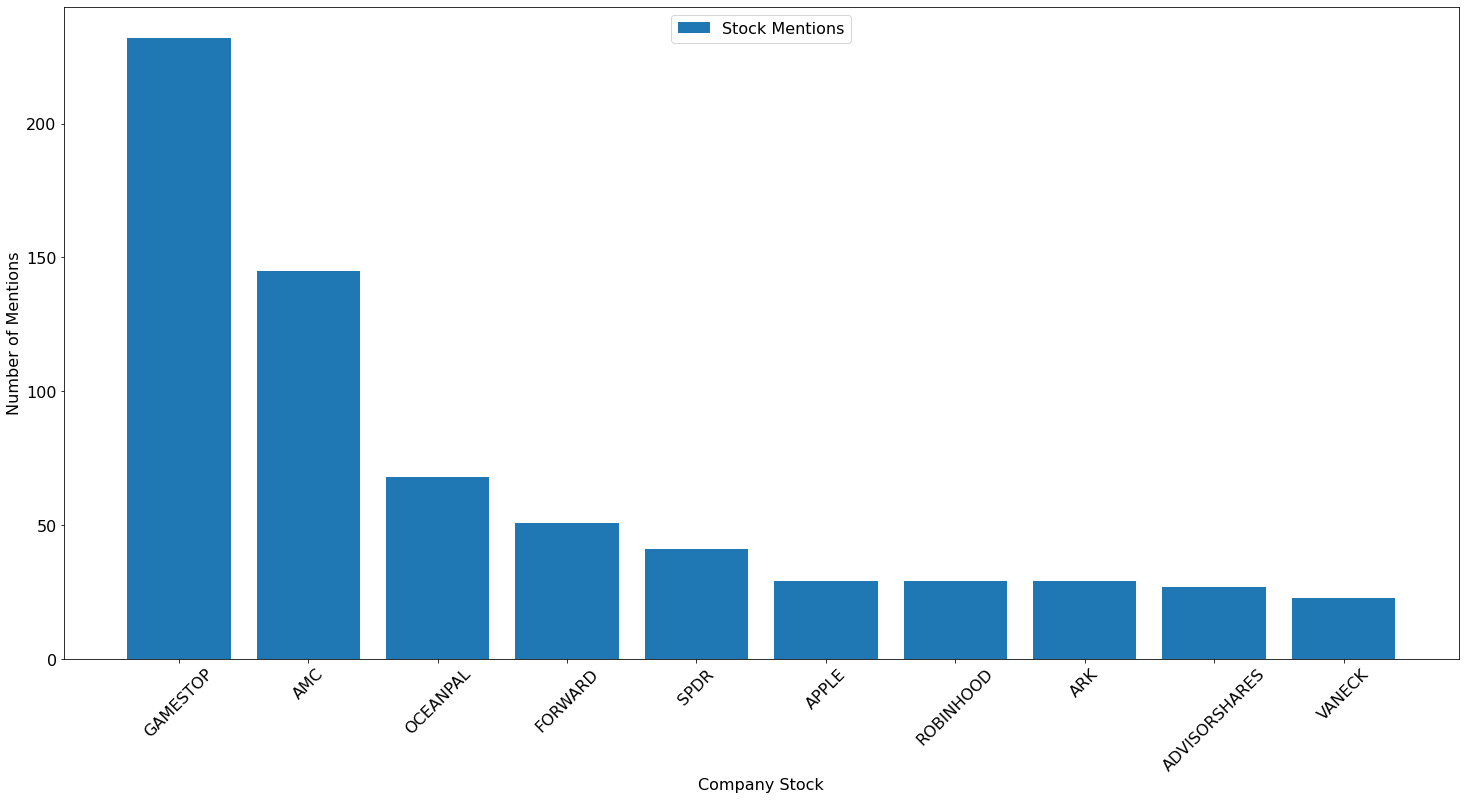

In [296]:
# Plotting the top 20 by count tickers mentioned.
plt.figure(figsize=(25,12))
plt.bar(x_vals, y_vals, label='Stock Mentions')
plt.ylabel("Number of Mentions", fontsize=16)
plt.xlabel("Company Stock", fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.legend(loc="upper center", fontsize=16)
plt.show()

In [315]:
# Function to search for specific company ticker and display it
def display_ticker_mentions(ticker=None):
    if (type(ticker) == int):
        return
    elif (len(ticker) < 5):
        try:
            company_name = tickers_company_dict[ticker]
        except KeyError:
            return "Make Sure it is a real ticker"
    else:
        company_name = ticker.upper()
    
    company_name = ticker.upper()
    company_data = freq_table_final.loc[freq_table_final['new_index'] == company_name]['Frequency'][0]
    
    # plotting data
    x_pos = [0.5]
    y_vals = company_data
    
    plt.figure(figsize=(25,12))
    plt.bar(x_pos, y_vals, label='Stock Mentions', width=0.1)
    plt.ylabel("Number of Mentions", fontsize=16)
    plt.xlabel("Company Stock", fontsize=16)
    
    plt.axis([0,1,0, company_data + 50])
    
    plt.xticks(x_pos, [company_name], fontsize=16, rotation=45)
    plt.yticks(fontsize=16)
    
    
    plt.legend(loc="upper center", fontsize=16)
    plt.show()

# Input the name of any stock you want here. please make sure it is in CAPITAL letters.
display_ticker_mentions(ticker="TESLA")

KeyError: 0

In [298]:
# Goal2: Classification of sentiment of each comment/sentence. To then visualise the overall sentiment of thousands of comments downloaded and processed
# Starting SPARK NLP Preproccessing the text data
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp

In [299]:
# Creating a Spark-NLP Data Pipeline
spark = sparknlp.start()

22/01/17 15:16:13 WARN Utils: Your hostname, Nikitas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.2.198 instead (on interface en0)
22/01/17 15:16:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/nikitaizmailov/ml/nlp_project/lib/python3.9/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/nikitaizmailov/.ivy2/cache
The jars for the packages stored in: /Users/nikitaizmailov/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-668b27ab-34a3-4f37-acef-467d0f8e3666;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.4.0 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.

In [300]:
clean_untouched_df = all_comments_df.copy()
clean_untouched_df = clean_untouched_df[['body']]
clean_untouched_df = clean_untouched_df['body'].tolist()

In [301]:
comments_array_2d = np.array(clean_untouched_df)
comments_array_2d = comments_array_2d.reshape(-1, 1)
comments_array_2d = comments_array_2d.tolist()

In [302]:
 spark_comments_df = spark.createDataFrame(comments_array_2d).toDF('text')

In [303]:
# Using my own spark nlp pipeline
# Using 

# initial stage of the preprocessing pipeline. needed to do all the below transformations.
document = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# Breaks down sentence into list of words i.e. "Nike is better than Adidas" -> ['Nike', 'is', 'better', 'than', 'Adidas']
token = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Removes all dirty characters from text following a regex pattern and transforms words based on a provided dictionary
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normal")

# The actual sentiment pretrained model I am using to classifiy the comments
vivekn =  ViveknSentimentModel.pretrained() \
    .setInputCols(["document", "normal"]) \
    .setOutputCol("result_sentiment")

# Once we have our NLP pipeline ready to go, we might want to use our annotation results somewhere else where it is easy to use. The Finisher outputs annotation(s) values into a string.
finisher = Finisher() \
    .setInputCols(["result_sentiment"]) \
    .setOutputCols("final_sentiment")

pipeline = Pipeline().setStages([document, token, normalizer, vivekn, finisher])

pipelineModel = pipeline.fit(spark_comments_df)
result = pipelineModel.transform(spark_comments_df)

# result.select("final_sentiment").show(truncate=False).

sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
[ | ]sentiment_vivekn download started this may take some time.
Approximate size to download 873.6 KB
Download done! Loading the resource.
[OK!]


In [304]:
# Transforming the spark nlp df to a pandas df
df_sentiment_comments = result.toPandas()

In [305]:
# DataFrame with all the comments and their respective positive/neutral/negative sentiment for each comment
df_sentiment_comments['final_sentiment'] = df_sentiment_comments['final_sentiment'].astype(str)
df_sentiment_comments['final_sentiment'][0]

"['negative']"

In [306]:
# Overall Sentiment of all the comments provided:
df_overall_sentiment = df_sentiment_comments['final_sentiment'].value_counts()
df_overall_sentiment = df_overall_sentiment.reset_index()

In [307]:
# Overall Sentiment of the comments
# As we can see we have more negative than positive comments
df_overall_sentiment

,index,final_sentiment
0,['negative'],10546
1,['positive'],8774
2,['na'],3234
3,[],220


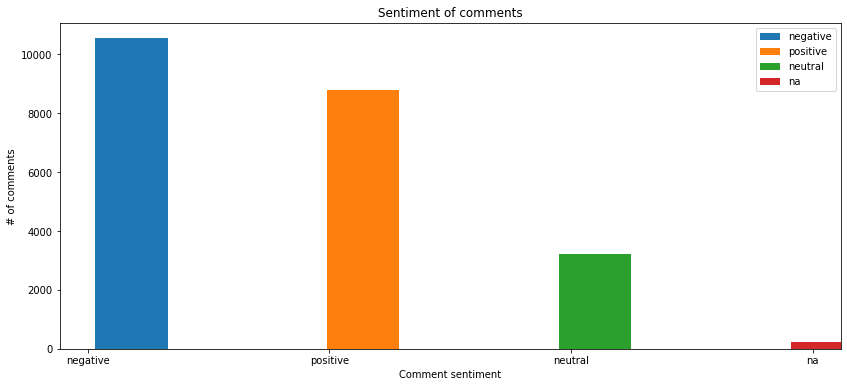

In [308]:
# Plot a histogram of the sentiment data
plt.figure(figsize=(14,6))
neg_comments = df_sentiment_comments["final_sentiment"][df_sentiment_comments["final_sentiment"] == "['negative']"]
pos_comments = df_sentiment_comments["final_sentiment"][df_sentiment_comments["final_sentiment"] == "['positive']"]
neutral_comments = df_sentiment_comments["final_sentiment"][df_sentiment_comments["final_sentiment"] == "['na']"]
unidentified_comments = df_sentiment_comments["final_sentiment"][df_sentiment_comments["final_sentiment"] == "[]"]
plt.hist([
         neg_comments,
         pos_comments,
         neutral_comments,
         unidentified_comments,
    ],
     width=0.3,
     label=["negative", "positive", "neutral", "na"])
plt.legend()
plt.title("Sentiment of comments")

plt.xticks([0,1,2,3],['negative', 'positive', 'neutral', 'na'])
plt.xlabel("Comment sentiment")
plt.ylabel("# of comments")
plt.show()

## The End